<a href="https://colab.research.google.com/github/WxAnalyst/Event_Review/blob/main/Event_Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Event Review
Author: John Hinsberger

This program is designed to fetch weather data for a specific date and time. Data will be gathered using the Herbie library and displayed using MetPy's declarative plotting.

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()
!mamba install -q -c conda-forge cartopy contextily pyproj pyepsg xesmf netCDF4 herbie-data metpy eccodes xarray  #installs everything using the conda environment we installed above

In [1]:
from cartopy import crs as ccrs, feature as cfeature
import matplotlib.pyplot as plt
import xarray as xr
import metpy
import numpy as np
from metpy.calc import reduce_point_density, wind_components
from metpy.plots import ContourPlot, MapPanel, ImagePlot, PanelContainer, FilledContourPlot, PlotObs, BarbPlot
from metpy.units import units
from herbie import Herbie

/usr/local/lib/python3.8/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


 ╭─────────────────────────────────────────────────╮
 │ I'm building Herbie's default config file.      │
 ╰╥────────────────────────────────────────────────╯
 👷🏻‍♂️
 ╭─────────────────────────────────────────────────╮
 │ You're ready to go.                             │
 │ You may edit the config file here:              │
 │ /root/.config/herbie/config.toml                │
 ╰╥────────────────────────────────────────────────╯
 👷🏻‍♂️


In [7]:
event_date = "2023-03-06" #@param {type:"date"}
event_time = 0 #@param {type:"slider", min:0, max:23, step:1}
event_time=str(event_time)+":00"
dtg = event_date+" "+event_time
mdl = "nbm" #@param ['hrrr','nbm']
#@markdown <b>Select forecast hour</b><br />
fhr = 6 #@param {type:"slider", min:0, max:12, step:1}
step = np.arange(0, 49, 1, dtype=int)
dt = str.split(event_date,'-')
elements = "severe" #@param ['severe','fire','winter']

def model(mdl):
  if mdl == 'hrrr':
    product = 'sfc'
  if mdl == 'nbm':
    product = 'co'
  if mdl == 'nam':
    product = 'conusnest.hiresf'
  if mdl == 'rap':
    product = 'awp130bgrb'
  if mdl == 'gfs':
    product = 'pgrb2.0p25'

  return product

def getSubsets(mdl, elements):
  """
  Retrieves the datasets and returns a metpy PanelContainer.
    mdl: 'hrrr', 'nbm'
    elements: 'severe', 'fire', 'winter'
  """
  if mdl == 'hrrr':
    if elements == 'severe':
      ds_pres = H.xarray(":MSLMA:mean sea level")
      ds_u = H.xarray(':UGRD:10 m above')
      ds_v = H.xarray(':VGRD:10 m above')
      ds_refl = H.xarray(":REFC:entire atmosphere")
      ds_height = H.xarray(":HGT:surface")
      ds_temp = H.xarray(":TMP:2 m")

      pressure = ds_pres.metpy.parse_cf('mslma',coordinates={'time':'time','vertical':ds_pres.mslma.GRIB_typeOfLevel,'longitude':'longitude','latitude':'latitude'})
      pressure = pressure.metpy.assign_y_x(force = True)
      pressure = pressure.metpy.convert_units('hPa')
      pressure = pressure.assign_attrs({"GRIB_units":"mb"})
      u = ds_u.metpy.parse_cf('u10', coordinates={'time':'time','vertical':ds_u.u10.GRIB_typeOfLevel,'longitude':'longitude','latitude':'latitude'})
      v = ds_v.metpy.parse_cf('v10', coordinates={'time':'time','vertical':ds_v.v10.GRIB_typeOfLevel,'longitude':'longitude','latitude':'latitude'})
      u = u.metpy.assign_y_x(force = True)
      v = v.metpy.assign_y_x(force = True)
      wind = xr.merge([u,v], compat='override')
      refl = ds_refl.metpy.parse_cf('refc',coordinates={'time':'time','vertical':ds_refl.refc.GRIB_typeOfLevel,'longitude':'longitude','latitude':'latitude'})
      refl = refl.metpy.assign_y_x(force = True)
      topo = ds_height.metpy.parse_cf('orog',coordinates={'time':'time','vertical':ds_height.orog.GRIB_typeOfLevel,'longitude':'longitude','latitude':'latitude'})
      topo = topo.metpy.assign_y_x(force = True)

      if elements == 'severe':
        contour = FilledContourPlot()
        contour.data = refl
        contour.colorbar = 'vertical'
        contour.contours = list(range(5 , 80, 5))
        contour.colormap = 'NWSReflectivity'

        height = ImagePlot()
        height.data = topo
        height.smooth_field = 3
        height.colormap = 'terrain'
        height.plot_units = 'ft'
        height.image_range = (-2000, 13000)

        contour_prs = ContourPlot()
        contour_prs.data = pressure
        contour_prs.linecolor = 'black'
        contour_prs.clabels = True
        contour_prs.label_fontsize = 12

        barb = BarbPlot()
        barb.data = wind
        barb.field = ('u10','v10')
        barb.color = 'black'
        barb.plot_units = 'kt'
        barb.skip = (5,5)
        barb.barblength = 5.5

        panel = MapPanel()
        panel.projection = ccrs.LambertConformal()
        panel.area = [-118, -110, 41, 47]   # or 'id', 'us'

        panel.layers = ['coastline', 'borders', 'states', 'uscounties']
        panel.layers_linewidth = [2, 3, 3, 2]
        panel.left_title = ds_refl.model.upper() +" "+H.product_description+": \n"+"Valid: "+ds_refl.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()
        panel.title_fontsize = 18
        panel.right_title = ds_refl.refc.GRIB_name +"\n" + ds_pres.mslma.GRIB_name+"\n10 meter wind (kt)"
        panel.plots = [height, contour, contour_prs, barb]
      
        pc = PanelContainer()
        pc.size = (30, 20)
        pc.panels = [panel]
        #pc.show()
        return pc
      if elements == 'fire':
        pass
      if elements == 'winter':
        pass
  
  if mdl =='nbm':
    if elements == 'severe':
      ds_temp = H.xarray(":TMP:2 m")
      ds_refl = H.xarray(":MAXREF:1000 m")
      ds_refl = ds_refl.rename_vars({'unknown':'refl'})
      ds_dir = H.xarray(":WDIR:10 m")
      ds_spd = H.xarray(":WIND:10 m")
      ds_spd = ds_spd.metpy.parse_cf('si10', coordinates={'time':'time','vertical':ds_spd.si10.GRIB_typeOfLevel,'longitude':'longitude','latitude':'latitude'})   * units('kt')
      ds_dir = ds_dir.metpy.parse_cf('wdir10',coordinates={'time':'time','vertical':ds_dir.wdir10.GRIB_typeOfLevel,'longitude':'longitude','latitude':'latitude'})  * units.deg
      ds_dir = ds_dir.metpy.assign_y_x(force = True)
      ds_dir = ds_dir.assign_attrs({"GRIB_units":"degrees"})
      ds_spd = ds_spd.assign_attrs({"GRIB_units":"knots"})
      ds_spd = ds_spd.metpy.assign_y_x(force = True)
      u, v = wind_components(ds_spd, ds_dir)
      u = u.assign_attrs({"GRIB_units":"kts"})
      v = v.assign_attrs({"GRIB_units":"kts"})
      u.name = "u"      # required to run the xr.merge
      v.name = "v"      # required to run the xr.merge
      wind = xr.merge([u,v])
      refl = ds_refl.metpy.parse_cf('refl',coordinates={'time':'time','vertical':ds_refl.refl.GRIB_typeOfLevel,'longitude':'longitude','latitude':'latitude'})
      refl = refl.metpy.assign_y_x(force = True)
      refl = refl.assign_attrs({"GRIB_units":"dBz","GRIB_name":"Max Reflectivity"})
      
      contour = FilledContourPlot()
      contour.data = refl
      contour.colorbar = 'vertical'
      contour.contours = list(range(5 , 80, 5))
      contour.colormap = 'NWSReflectivity'

      barb = BarbPlot()
      barb.data = wind
      barb.field = ('u','v')
      barb.color = 'black'
      barb.plot_units = 'kt'
      barb.skip = (5,5)
      barb.barblength = 5.5

      panel = MapPanel()
      panel.projection = ccrs.LambertConformal()
      panel.area = [-118, -110, 41, 47]   # or 'id', 'us'

      panel.layers = ['coastline', 'borders', 'states', 'uscounties']
      panel.layers_linewidth = [2, 3, 3, 2]
      panel.left_title = ds_refl.model.upper() +" "+H.product_description+": \n"+"Valid: "+ds_refl.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()
      panel.title_fontsize = 18
      panel.right_title = refl.GRIB_name +"\n" + "10 meter wind (kt)"
      panel.plots = [contour, barb]
      
      pc = PanelContainer()
      pc.size = (30, 20)
      pc.panels = [panel]
      #pc.show()
      return pc
      #grids.extend((ds_temp, ds_refl, ds_dir, ds_spd))
      #return grids
    
    if elements == 'fire':
      pass
    
    if elements == 'winter':
      pass


'\ndef makePanel(mdl, elements):\n  if mdl == \'hrrr\':\n    pressure = ds_pres.metpy.parse_cf(\'mslma\',coordinates={\'time\':\'time\',\'vertical\':ds_pres.mslma.GRIB_typeOfLevel,\'longitude\':\'longitude\',\'latitude\':\'latitude\'})\n    pressure = pressure.metpy.assign_y_x(force = True)\n    pressure = pressure.metpy.convert_units(\'hPa\')\n    pressure = pressure.assign_attrs({"GRIB_units":"mb"})\n    u = ds_u.metpy.parse_cf(\'u10\', coordinates={\'time\':\'time\',\'vertical\':ds_u.u10.GRIB_typeOfLevel,\'longitude\':\'longitude\',\'latitude\':\'latitude\'})\n    v = ds_v.metpy.parse_cf(\'v10\', coordinates={\'time\':\'time\',\'vertical\':ds_v.v10.GRIB_typeOfLevel,\'longitude\':\'longitude\',\'latitude\':\'latitude\'})\n    u = u.metpy.assign_y_x(force = True)\n    v = v.metpy.assign_y_x(force = True)\n    wind = xr.merge([u,v], compat=\'override\')\n    refl = ds_refl.metpy.parse_cf(\'refc\',coordinates={\'time\':\'time\',\'vertical\':ds_refl.refc.GRIB_typeOfLevel,\'longitude\':\'

In [8]:
H = Herbie(dtg, model=mdl, product=model(mdl), fxx=fhr)

✅ Found ┊ model=nbm ┊ product=co ┊ 2023-Mar-06 00:00 UTC F06 ┊ GRIB2 @ aws ┊ IDX @ nomads


In [9]:
graphic = getSubsets(mdl, elements)

👨🏻‍🏭 Created directory: [/root/data/nbm/20230306]


/usr/local/lib/python3.8/site-packages/metpy/xarray.py:382: UserWarning: More than one time coordinate present for variable "wdir10".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'
/usr/local/lib/python3.8/site-packages/metpy/xarray.py:382: UserWarning: More than one time coordinate present for variable "si10".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'
/usr/local/lib/python3.8/site-packages/metpy/xarray.py:382: UserWarning: More than one time coordinate present for variable "refl".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'


/usr/local/lib/python3.8/site-packages/metpy/xarray.py:382: UserWarning: More than one time coordinate present for variable "u".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'


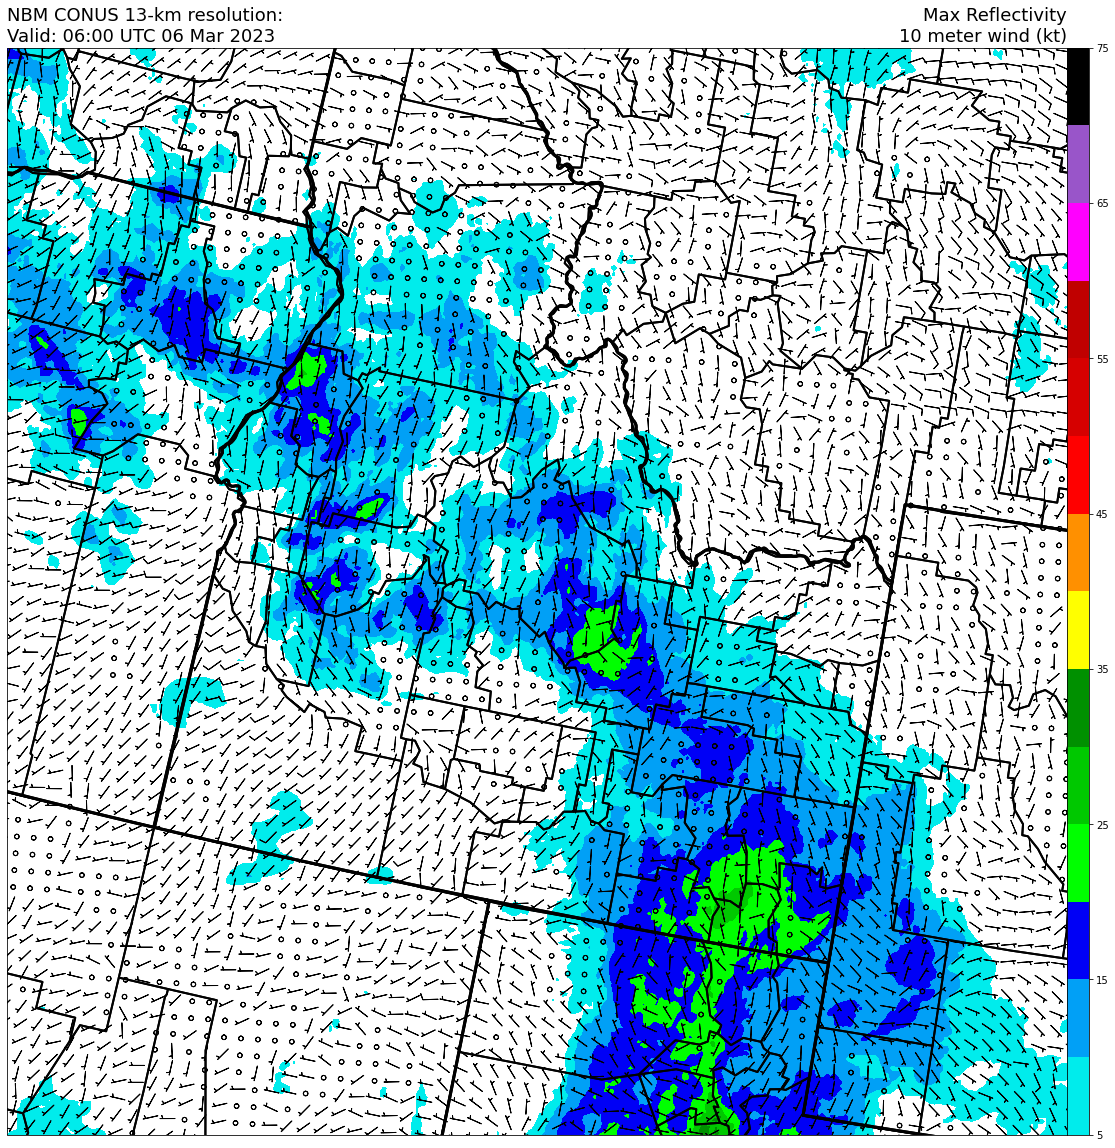

In [10]:
# Running this cell will take around 2 to 5 minutes
graphic.show()